In [1]:
!pip install natasha

In [2]:
import csv
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM, Dropout, Activation, Embedding,SimpleRNN,GRU
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk import word_tokenize
STOPWORDS = set(stopwords.words('russian'))
from string import punctuation
punct = list(punctuation)
from tqdm import tqdm
from keras.callbacks import ReduceLROnPlateau,EarlyStopping
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report, roc_auc_score
from scipy import stats
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, GRU, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.utils import resample


np.random.seed(42)
tf.random.set_seed(42)


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\a.n.piskunov\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [3]:
data_test = pd.read_csv(r'C:\Users\a.n.piskunov\Downloads\test.csv')
data_train = pd.read_csv(r'C:\Users\a.n.piskunov\Downloads\train.csv')


In [4]:
articles_test=data_test['text'].to_list()
articles_train=data_train['text'].to_list()
labels_train=data_train['class'].to_list()
labels_test=data_test['class'].to_list()

In [5]:
from natasha import Doc, Segmenter, MorphVocab
from natasha import NewsEmbedding, NewsMorphTagger
import re
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Инициализация компонентов Natasha
segmenter = Segmenter()
morph_vocab = MorphVocab()
emb = NewsEmbedding()
morph_tagger = NewsMorphTagger(emb)

# Список месяцев
months = [
    "январь", "февраль", "март", "апрель", "май", "июнь",
    "июль", "август", "сентябрь", "октябрь", "ноябрь", "декабрь"
]

# Стоп-слова
russian_stopwords = set(stopwords.words("russian"))
russian_stopwords.discard('за')  # Убираем из стоп-слов "за"
russian_stopwords.update(['кг', 'сумма', 'тч', 'мл', 'счёт'])  # Добавляем свои слова

# Функция очистки текста
def clear(text, russian_stopwords, segmenter, morph_vocab, morph_tagger, months):
    # Удаляем даты из текста
    date_pattern = r"(\d{0,4}[./-]?)"
    cleaned_text = re.sub(date_pattern, "", text)
    
    # Токенизация и удаление стоп-слов
    tokens = word_tokenize(cleaned_text.lower())
    tokens = [token for token in tokens if token not in russian_stopwords]
    tokens = [token for token in tokens if token not in string.punctuation]
    cleaned_text = ' '.join(tokens)
    
    # Используем Natasha для морфологической обработки
    doc = Doc(cleaned_text)
    doc.segment(segmenter)
    doc.tag_morph(morph_tagger)
    
    # Лемматизация
    for token in doc.tokens:
        token.lemmatize(morph_vocab)
    
    # Убираем месяцы и короткие слова
    lemmas = [token.lemma for token in doc.tokens if token.lemma not in months and len(token.lemma) > 1]
    
    return ' '.join(lemmas)

In [6]:
for i in tqdm(range(len(articles_test))):
    articles_test[i]=clear(articles_test[i], russian_stopwords, segmenter, morph_vocab, morph_tagger, months)
    
for i in tqdm(range(len(articles_train))):
    articles_train[i]=clear(articles_train[i], russian_stopwords, segmenter, morph_vocab, morph_tagger, months)

100%|███████████████████████████████████████████████████████████████████████████████| 400/400 [00:02<00:00, 190.57it/s]


In [7]:
vocab_size =5000
embedding_dim =64
max_length =200
oov_tok = '<OOV>' 

In [8]:
train_articles = articles_train
train_labels = labels_train
validation_articles = articles_test
validation_labels = labels_test

In [9]:
print('train_articles' ,len(train_articles))
print('train_labels', len(train_labels))
print('validation_articles', len(validation_articles))
print('validation_labels', len(validation_labels))

train_articles 400
train_labels 400
validation_articles 100
validation_labels 100


In [10]:
tokenizer = Tokenizer(num_words = vocab_size)
tokenizer.fit_on_texts(train_articles)
word_index = tokenizer.word_index

In [11]:
train_sequences = tokenizer.texts_to_sequences(train_articles)
len(train_sequences)

400

In [12]:
train_padded = pad_sequences(train_sequences, maxlen=max_length)

In [13]:
len(train_padded),len(train_padded[0])

(400, 200)

In [14]:
validation_sequences = tokenizer.texts_to_sequences(validation_articles)
validation_padded = pad_sequences(validation_sequences, maxlen=max_length)

In [15]:
dict_={}
for i,x in tqdm(enumerate(set(labels_train))):
    dict_[x]=i
dict_

9it [00:00, ?it/s]


{'FOOD_GOODS': 0,
 'BANK_SERVICE': 1,
 'LEASING': 2,
 'NOT_CLASSIFIED': 3,
 'LOAN': 4,
 'REALE_STATE': 5,
 'SERVICE': 6,
 'TAX': 7,
 'NON_FOOD_GOODS': 8}

In [16]:
training_label_seq = np.array([dict_[train_labels[i]] for i in tqdm(range(len(train_labels)))])
validation_label_seq = np.array([dict_[np.array(validation_labels)[i]] for i in tqdm(range(len(validation_labels)))])


100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 11150.62it/s]


In [17]:
train_labels[0], training_label_seq[0]


('TAX', 7)

In [18]:
pd.DataFrame(training_label_seq).value_counts()


8    77
0    72
6    70
1    39
7    38
4    33
2    31
5    22
3    18
dtype: int64

In [19]:
pd.DataFrame(validation_label_seq).value_counts()


8    19
0    18
6    18
1    10
7    10
4     8
2     7
3     5
5     5
dtype: int64

Text(0, 0.5, 'Count')

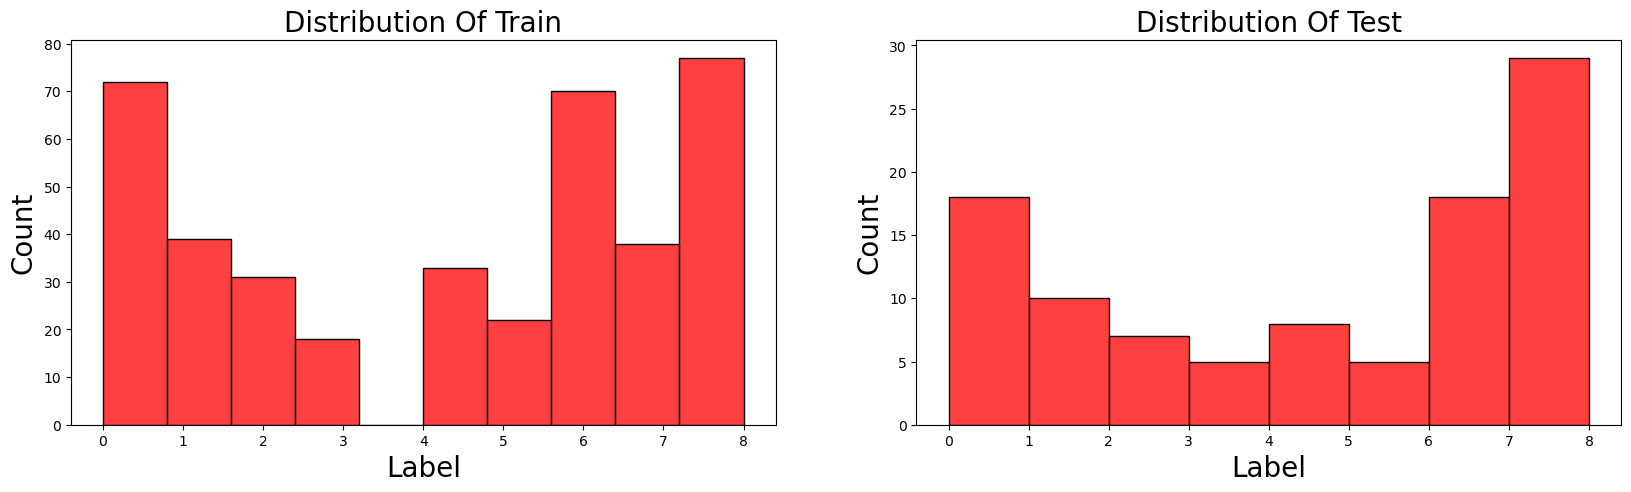

In [20]:
plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
plt.title("Distribution Of Train",fontsize=20)
sns.histplot(training_label_seq,color='red')
plt.xlabel('Label',fontsize=20)
plt.ylabel("Count",fontsize=20)
plt.subplot(1,2,2)
plt.title("Distribution Of Test",fontsize=20)
sns.histplot(validation_label_seq,color='red')
plt.xlabel('Label',fontsize=20)
plt.ylabel("Count",fontsize=20)

In [21]:
print("Train padded shape:", train_padded.shape) 
print("Training labels shape:", training_label_seq.shape)  
print("Unique labels in training data:", np.unique(training_label_seq))  

model = Sequential([
    Embedding(input_dim=20000, output_dim=100, input_length=200),
    Bidirectional(GRU(128)),  
    Dropout(0.3),
    Dense(9, activation='softmax')  
   ])

model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-6)
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


history = model.fit(train_padded, training_label_seq, epochs=50,
                       validation_data=(validation_padded, validation_label_seq),
                       callbacks=[reduce_lr, early_stop])
   

Train padded shape: (400, 200)
Training labels shape: (400,)
Unique labels in training data: [0 1 2 3 4 5 6 7 8]
Epoch 1/50


C:\ProgramData\Anaconda\lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


13/13 ━━━━━━━━━━━━━━━━━━━━ 7s 188ms/step - accuracy: 0.2270 - loss: 2.1549 - val_accuracy: 0.3700 - val_loss: 2.0007 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 135ms/step - accuracy: 0.4006 - loss: 1.9542 - val_accuracy: 0.4500 - val_loss: 1.7702 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.4597 - loss: 1.6523 - val_accuracy: 0.5200 - val_loss: 1.2666 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 130ms/step - accuracy: 0.5862 - loss: 1.1257 - val_accuracy: 0.7000 - val_loss: 0.8772 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 134ms/step - accuracy: 0.8091 - loss: 0.7159 - val_accuracy: 0.8000 - val_loss: 0.5641 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 143ms/step - accuracy: 0.8832 - loss: 0.4203 - val_accuracy: 0.8400 - val_loss: 0.4434 - learning_rate: 0.0010
Epoch 7/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 140ms/step - accuracy: 0.9438 - loss: 0.2502 - val_accurac

In [22]:
pd.DataFrame(history.history)


,accuracy,loss,val_accuracy,val_loss,learning_rate
0,0.2700,2.126511,0.37,2.000691,0.0010
1,0.3875,1.930497,0.45,1.770226,0.0010
2,0.4675,1.576592,0.52,1.266578,0.0010
3,0.6450,1.044869,0.70,0.877184,0.0010
4,0.8250,0.639289,0.80,0.564094,0.0010
5,0.9150,0.359542,0.84,0.443387,0.0010
6,0.9675,0.206211,0.92,0.291549,0.0010
7,0.9800,0.119522,0.92,0.234671,0.0010
8,0.9950,0.075944,0.93,0.206312,0.0010
9,0.9950,0.047718,0.93,0.167319,0.0010


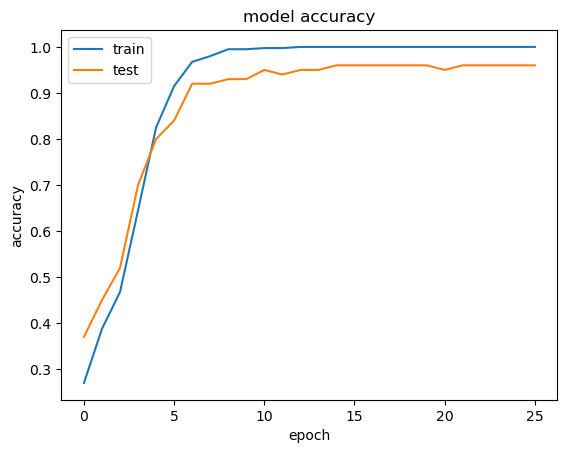

In [23]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

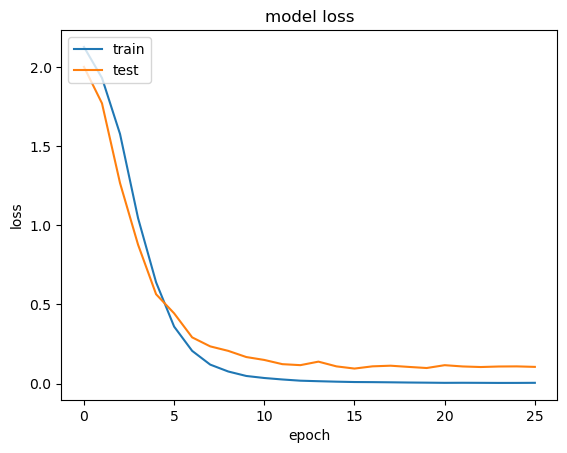

In [24]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [25]:
y_pred=model.predict(validation_padded)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 159ms/step


In [26]:
pred=[np.argmax(i) for i in tqdm(y_pred)]
df=pd.DataFrame()
df['Prediction'],df['actual']=pred,validation_label_seq
df

100%|█████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 96442.95it/s]


,Prediction,actual
0,0,0
1,6,6
2,2,2
3,1,1
4,0,0
...,...,...
95,8,8
96,3,3
97,0,0
98,0,8


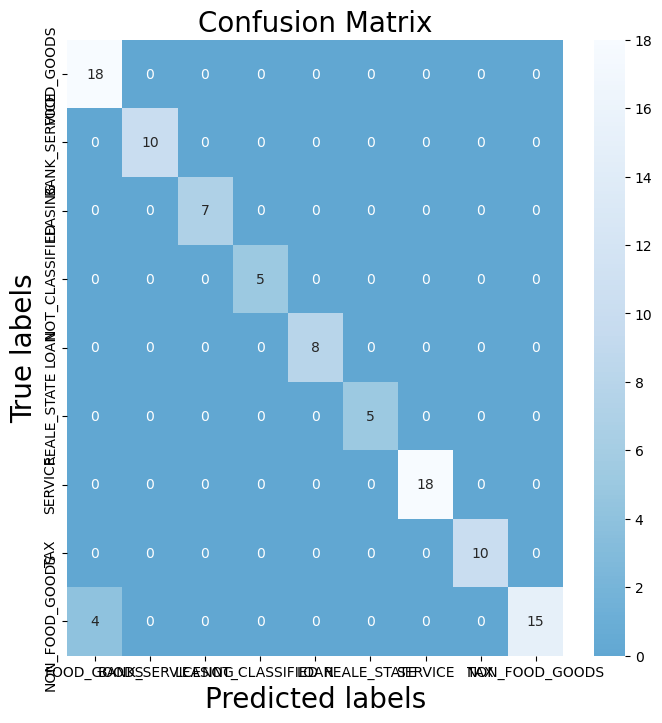

array([[18,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0, 10,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  7,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  5,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  8,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  5,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0, 18,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 10,  0],
       [ 4,  0,  0,  0,  0,  0,  0,  0, 15]], dtype=int64)

In [27]:
CM = confusion_matrix(validation_label_seq,pred)
plt.figure(figsize=(8,8))
ax= plt.subplot()
sns.heatmap(CM, center = True, fmt='g',ax=ax,annot=True,cmap='Blues_r')
ax.set_xlabel('Predicted labels',fontsize=20)
ax.set_ylabel('True labels',fontsize=20) 
ax.set_title('Confusion Matrix',fontsize=20)
ax.xaxis.set_ticklabels(dict_.keys()) 
ax.yaxis.set_ticklabels(dict_.keys())
plt.show()
CM

In [28]:
pred_prob = model.predict(validation_padded)


print("Predicted probabilities shape:", pred_prob.shape)


if len(pred_prob.shape) == 1:
    pred_prob = np.expand_dims(pred_prob, axis=1)  


if pred_prob.shape[1] == 1:
    pred_prob = np.hstack([1 - pred_prob, pred_prob]) 


pred_labels = np.argmax(pred_prob, axis=1) 


classification_report_result = classification_report(validation_label_seq, pred_labels)
print('Classification Report:n', classification_report_result)


roc_auc = roc_auc_score(validation_label_seq, pred_prob, multi_class='ovr')  
print('ROC AUC Score:', roc_auc)


gini_coefficient = 2 * roc_auc - 1
print('Gini Coefficient:', gini_coefficient)


ks_statistic, ks_p_value = stats.ks_2samp(pred_prob[validation_label_seq == 0][:, 1], 
                                           pred_prob[validation_label_seq == 1][:, 1])
print('Kolmogorov-Smirnov Statistic:', ks_statistic)
print('Kolmogorov-Smirnov p-value:', ks_p_value)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
Predicted probabilities shape: (100, 9)
Classification Report:n               precision    recall  f1-score   support

           0       0.82      1.00      0.90        18
           1       1.00      1.00      1.00        10
           2       1.00      1.00      1.00         7
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00         8
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00        18
           7       1.00      1.00      1.00        10
           8       1.00      0.79      0.88        19

    accuracy                           0.96       100
   macro avg       0.98      0.98      0.98       100
weighted avg       0.97      0.96      0.96       100

ROC AUC Score: 0.9993409826885793
Gini Coefficient: 0.9986819653771586
Kolmogorov-Smirnov Statistic: 1.0
Kolmogorov-Smirnov p-value: 1.5240289839832176e-07


In [29]:
def get_code(N):
    for x,y in dict_.items():
        if y==N:
            return x

In [30]:
txt = ['Оплата штрафа']

seq = tokenizer.texts_to_sequences(txt)
padded = pad_sequences(seq, maxlen=max_length)
pred = model.predict(padded)

print(get_code(np.argmax(pred)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
TAX


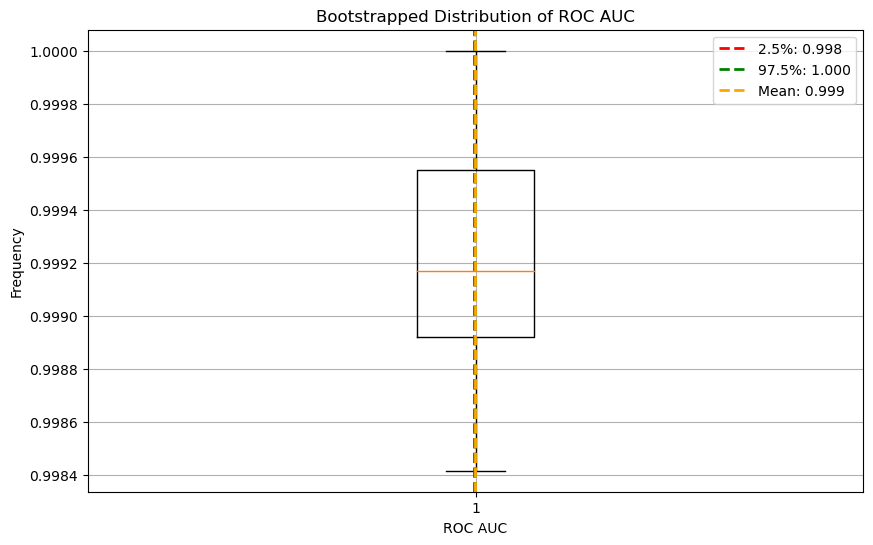

95% Confidence Interval for ROC AUC: [0.998, 1.000]


In [31]:
n_iterations = 10
n_size = len(validation_label_seq) 


bootstrapped_roc_aucs = []


for i in range(n_iterations):
    indices = resample(range(n_size), n_samples=n_size)
    y_true_bs = validation_label_seq[indices]
    y_prob_bs = pred_prob[indices]

    unique_classes = np.unique(y_true_bs)

    if len(unique_classes) == 2: 
        roc_auc_bs = roc_auc_score(y_true_bs, y_prob_bs[:, 1])  
    else:  
        if len(unique_classes) != y_prob_bs.shape[1]:
            raise ValueError("Number of classes in y_true not equal to the number of columns in 'y_prob'")
        roc_auc_bs = roc_auc_score(y_true_bs, y_prob_bs, multi_class='ovr')
    
    bootstrapped_roc_aucs.append(roc_auc_bs)


bootstrapped_roc_aucs = np.array(bootstrapped_roc_aucs)


lower_bound = np.percentile(bootstrapped_roc_aucs, 2.5)
upper_bound = np.percentile(bootstrapped_roc_aucs, 97.5)


plt.figure(figsize=(10, 6))
plt.boxplot(bootstrapped_roc_aucs)
plt.axvline(lower_bound, color='red', linestyle='dashed', linewidth=2, label=f'2.5%: {lower_bound:.3f}')
plt.axvline(upper_bound, color='green', linestyle='dashed', linewidth=2, label=f'97.5%: {upper_bound:.3f}')
plt.axvline(np.mean(bootstrapped_roc_aucs), color='orange', linestyle='dashed', linewidth=2, label=f'Mean: {np.mean(bootstrapped_roc_aucs):.3f}')

plt.title('Bootstrapped Distribution of ROC AUC')
plt.xlabel('ROC AUC')
plt.ylabel('Frequency')
plt.legend()
plt.grid()
plt.show()

print(f'95% Confidence Interval for ROC AUC: [{lower_bound:.3f}, {upper_bound:.3f}]')
